# Setup Environment

In [1]:
# Modify the pathname if needed

pathname = '/content/drive/MyDrive/FPL_AI'

In [36]:
# # Connect and Mount your Google Drive

# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
%%capture

# install packages

!pip install keras
!pip install tensorflow
!pip install optuna

In [4]:
# Set Seed 

seed_value=123

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# Import libraries

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from operator import itemgetter

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers.merge import concatenate

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None

import optuna
from optuna.integration import TFKerasPruningCallback

from matplotlib import pyplot as plt

In [6]:
# Adjust display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Model Data Preparation

In [7]:
# Set data parameters, features and target

n_timesteps = 33  # lags used in features
n_features1 = 18  # time series features
n_features2 = 4   # non-ts features
n_output_ts = 5   # output timesteps
n_output = 1      # no. of outputs

features1 = ['bps','team_scored_past','team_conceded_past','opponent_scored_past','opponent_conceded_past','position_points','was_home',
             'value','minutes','goals_scored','goals_conceded','assists','team_goals_scored','influence','creativity','threat','selected','transfers_balance']
features2 = ['opponent_scored_past','opponent_conceded_past','position_points','was_home']
target = 'bps'

In [8]:
# Load master data

def load_data():
  
    master = pd.read_csv(pathname+'/data/master_data.csv')

    return master

master_data = load_data()

In [9]:
# Sort values, rename columns, change column type

def clean_data(df):

    df = df[['name','player_kickoff_id','kickoff_time']+features1]
    df.sort_values(['kickoff_time'],inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.rename({'kickoff_time':'kickoff_id'},axis=1,inplace=True)
    df['kickoff_id'] = df.index.astype(str)
    df['player_kickoff_id'] = df['player_kickoff_id'].astype(str)
    df['was_home'] = df['was_home'].astype(int)

    return df

master_data = clean_data(master_data)

In [10]:
# restrict data scope

def filter_app(df):
    
    print('All data: ',df.shape)
    df = df[(df.bps>0)&(df.bps<50)]
    print('Filtered Data: ',df.shape)

    return df

filtered_data = filter_app(master_data)

All data:  (119634, 21)
Filtered Data:  (57170, 21)


In [11]:
# Create player_list which filters out players that have played a total of less than 38 games across all seasons

def create_player_list(df):

    player_list = df[['name','minutes']].groupby(['name'],as_index=False).agg({'minutes':'count'}).reset_index(drop=True)
    print('Players before filter: ',player_list.shape)

    player_list = player_list[player_list['minutes'] >= n_timesteps+n_output_ts]
    player_list.drop('minutes',axis=1,inplace=True)
    print('Players after filter: ',player_list.shape)

    return player_list.name

players = create_player_list(filtered_data)

Players before filter:  (1278, 2)
Players after filter:  (538, 1)


In [12]:
# filter data based on player_list

def filter_data(df):

    print('Data before player filter: ', df.shape)
    df = df[df['name'].isin(players)].reset_index(drop=True)
    print('Data after player filter: ', df.shape)

    return df

filtered_data = filter_data(filtered_data)

Data before player filter:  (57170, 21)
Data after player filter:  (47031, 21)


In [14]:
# Normalize data

def scale_data(df):

    norm_scaler = MinMaxScaler()
    df1 = df.copy()
    num_cols = df1.select_dtypes(include=np.number).columns.tolist()
    df1.loc[:,num_cols] = norm_scaler.fit_transform(df1[num_cols])    

    return df1

data = scale_data(filtered_data)

In [15]:
data.head(3)

,name,player_kickoff_id,kickoff_id,bps,team_scored_past,team_conceded_past,opponent_scored_past,opponent_conceded_past,position_points,was_home,value,minutes,goals_scored,goals_conceded,assists,team_goals_scored,influence,creativity,threat,selected,transfers_balance
0,Christian Fuchs,22109,4,0.333333,0.325581,0.706897,0.197674,1.0,0.000000,0.0,0.173469,1.000000,0.0,0.222222,0.00,0.111111,0.266247,0.080749,0.091398,0.064514,0.371251
1,Daniel Drinkwater,26308,7,0.145833,0.325581,0.706897,0.197674,1.0,0.410757,0.0,0.173469,1.000000,0.0,0.222222,0.00,0.111111,0.077568,0.114687,0.064516,0.052464,0.371251
2,Demarai Gray,30722,9,0.312500,0.325581,0.706897,0.197674,1.0,0.410757,0.0,0.122449,0.741573,0.0,0.222222,0.25,0.111111,0.016771,0.016969,0.091398,0.003035,0.371251


# Random Forest - Baseline Model

In [16]:
# Features of current game that predict target for next game (shifted by 1 position in dataframe by player)

shift_features = ['bps_lag','value','minutes','goals_scored','goals_conceded','assists','team_goals_scored','influence','creativity','threat','selected','transfers_balance']

In [17]:
# Create target lag, shift features, sort data

def prepare_rf(df):
    
    df['bps_lag'] = df['bps']
    df_new = pd.DataFrame(columns=df.columns)

    for p in players:

        dfp = df[df.name==p]
        dfp[shift_features] = dfp[shift_features].shift(periods=1)
        df_new = df_new.append(dfp[1:])

    df_new.sort_values(['kickoff_id'],inplace=True)
    df_new.reset_index(drop=True,inplace=True)

    return df_new

data_rf = prepare_rf(data)
data_rf.head(3)

,name,player_kickoff_id,kickoff_id,bps,team_scored_past,team_conceded_past,opponent_scored_past,opponent_conceded_past,position_points,was_home,value,minutes,goals_scored,goals_conceded,assists,team_goals_scored,influence,creativity,threat,selected,transfers_balance,bps_lag
0,Federico Fernandez,37947,10000,0.250000,0.290698,0.827586,0.662791,0.379310,0.0,1.0,0.040816,1.0,0.0,0.111111,0.00,0.222222,0.327044,0.004096,0.032258,0.007488,0.371031,0.291667
1,Ainsley Maitland-Niles,3867,100000,0.291667,0.000000,1.000000,0.244186,0.775862,0.0,0.0,0.081633,1.0,0.0,0.333333,0.00,0.000000,0.033543,0.002926,0.016129,0.010672,0.370881,0.104167
2,Ollie Watkins,90330,100003,0.291667,0.244186,0.775862,0.000000,1.000000,1.0,1.0,0.275510,1.0,0.0,0.222222,0.25,0.111111,0.278826,0.072557,0.102151,0.303237,0.353940,0.375000


In [38]:
# Train Test split

def split_data(df_rf, test_pct):
    
    X = df_rf[list(set(features1+['bps_lag'])-set(['bps']))]
    y = df_rf[target]

    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=test_pct, random_state=123)
    display(X_train_.shape)
    display(y_train_.shape)    
    display(X_test_.shape)
    display(y_test_.shape)

    return X_train_, X_test_, y_train_, y_test_

X_train, X_test, y_train, y_test = split_data(data_rf, 0.1)

(41843, 18)

(41843,)

(4650, 18)

(4650,)

In [39]:
# Evaluate Model

def eval_rf(X_train_, X_test_, y_train_, y_test_):

    model = RandomForestRegressor()
    model.fit(X_train_, y_train_)
    y_hat = model.predict(X_test_)
    y_fit = model.predict(X_train_)
    print("Train MSE: ",mean_squared_error(y_train_, y_fit))
    print("Train MAE: ",mean_absolute_error(y_train_, y_fit))
    print("Test MSE: ",mean_squared_error(y_test_, y_hat))
    print("Test MAE: ",mean_absolute_error(y_test_, y_hat))

eval_rf(X_train, X_test, y_train, y_test)

Train MSE:  0.004895529578200056
Train MAE:  0.054722678624062944
Test MSE:  0.03509435608945638
Test MAE:  0.14769605734767025


# LSTM Model

In [20]:
# Generate input and output data for the Neural Network 

# Note:
# Since each player is its own time series, the input output is generated for each player individually and then appended
# The network has 2 separate inputs X1 and X2

def generate_ts(df):

    X1_=[]
    X2_=[]
    y_=[]

    for p in players:
        pdf = df[df.name==p]
        pdf['kickoff_id'] = pdf['kickoff_id'].astype(int)
        pdf.sort_values(['kickoff_id'],inplace=True)
        pdf.reset_index(drop=True,inplace=True)
        for i in range(0, len(pdf)-n_timesteps-n_output_ts+1):
            X1_.append(pdf.loc[i : i+n_timesteps-1, ['kickoff_id']+features1])
            X2_.append(pdf.loc[i+n_timesteps : i+n_timesteps+n_output_ts-1, ['kickoff_id']+features2])
            y_.append(pdf.loc[i+n_timesteps : i+n_timesteps+n_output_ts-1, ['kickoff_id','name']+[target]])

    X1_ = np.array(sorted(np.array(X1_), key=lambda x: x[0,0]))
    X2_ = np.array(sorted(np.array(X2_), key=lambda x: x[0,0]))
    y_ = np.array(sorted(np.array(y_), key=lambda x: x[0,0]))

    # y_name is later used to map the index with player_name
    y_name_ = y_

    # kickoff_id is dropped
    X1_ = X1_[:,:,1:]
    X2_ = X2_[:,:,1:]
    y_ = y_[:,:,2:]

    # average of 5 timesteps
    y_ = np.mean(y_,axis=1)
    y1 = y_.reshape(y_.shape[0],1,y_.shape[1]).astype(float)

    return X1_, X2_, y1, y_name_

X1, X2, y , y_name = generate_ts(data)
display(X1.shape)
display(X2.shape)
display(y.shape)

(27125, 33, 18)

(27125, 5, 4)

(27125, 1, 1)

In [21]:
def build_network(drop0, drop1a, drop1b, drop2, drop3, drop4,
                  rec_drop1, rec_drop2, rec_drop3, rec_drop4, 
                  n_lstm1, n_lstm2, n_lstm3, n_lstm4, n_dense1,
                  kernel_l2_1, kernel_l2_2, kernel_l2_3, kernel_l2_4, kernel_l2_5, kernel_l2_6,
                  lstm_activ1, lstm_activ2, lstm_activ3, lstm_activ4, dense_activ,
                  batch=None, alpha=None):

    # ------ ENCODER ------

    # first input 
    input1 = Input(shape=(n_timesteps,n_features1))
    dropout0 = Dropout(drop0)(input1)
    lstm1 = LSTM(n_lstm1,activation=lstm_activ1, return_sequences=True, recurrent_dropout=rec_drop1, kernel_regularizer=regularizers.l2(kernel_l2_1))(dropout0)
    dropout1a = Dropout(drop1a)(lstm1)
    lstm2 = LSTM(n_lstm2,activation=lstm_activ2, return_sequences=False, recurrent_dropout=rec_drop2, kernel_regularizer=regularizers.l2(kernel_l2_2))(dropout1a)
    dropout2 = Dropout(drop2)(lstm2)
    repeat1 = RepeatVector(n_output_ts)(dropout2)

    # ------ DECODER ------

    # second input 
    input2 = Input(shape=(n_output_ts,n_features2))
    dense1 = TimeDistributed(Dense(n_dense1, activation=dense_activ, kernel_regularizer=regularizers.l2(kernel_l2_3)))(input2)
    dropout1b = Dropout(drop1b)(dense1)

    # merge both models
    merge = concatenate([dropout1b, repeat1])

    lstm3 = LSTM(n_lstm3, activation=lstm_activ3, return_sequences=True, recurrent_dropout=rec_drop3, kernel_regularizer=regularizers.l2(kernel_l2_4))(merge)
    dropout3 = Dropout(drop3)(lstm3)
    lstm4 = LSTM(n_lstm4, activation=lstm_activ4, return_sequences=False, recurrent_dropout=rec_drop4, kernel_regularizer=regularizers.l2(kernel_l2_5))(dropout3)
    dropout4 = Dropout(drop4)(lstm4)
    output = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(kernel_l2_6))(dropout4)

    # build model
    model = Model(inputs=[input1, input2], outputs=output)

    # summarize layers
    print(model.summary())

    return model

In [22]:
def compile_model(model,alpha):
    
    model.compile(optimizer=Adam(learning_rate=alpha), loss='MeanSquaredError', metrics=['mse'])
    
    return model

In [23]:
def plot_loss(history_):

    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [24]:
def display_result(mse_train_,mse_test_,mae_train_,mae_test_):

    print('Train MSE')
    display(mse_train_)
    print('\n')
    print('Test MSE')
    display(mse_test_)
    print('\n')
    print('Train MAE')
    display(mae_train_)
    print('\n')
    print('Test MAE')
    display(mae_test_)

In [25]:
def eval_split(X1, X2, y, train_val_pct):

    n = int(train_val_pct*len(X1))
    X1_train_val, X2_train_val, y_train_val = X1[:n], X2[:n], y[:n]
    
    return X1_train_val, X2_train_val, y_train_val
                                                                                         
X1_train_val, X2_train_val, y_train_val = eval_split(X1, X2, y, 0.9)

In [26]:
# Evaluates model based on the hyperparameters passed

# Forecasting-based evluation is performed where in each iteration,
# the model trains on a specified window and tests on the next 5 timesteps * no. of players.
# 5 corresponds to n_output_ts

def eval_model(trial, X1_, X2_, y_, train_pct, epoch, **params):

    i=0
    mae_train, mse_train, mae_test, mse_test = 0,0,0,0

    y_test_all = []
    y_hat_all = []

    model = build_network(**params)
    model = compile_model(model,alpha=params['alpha'])

    test_len = n_output_ts*len(players) #approximates size of test set

    for n in range(len(X1_), int(np.floor(train_pct*len(X1_))), -test_len):

        print('Iteration: ',n)

        X1_train, X2_train, y_train = X1_[:(n-test_len)], X2_[:(n-test_len)], y_[:(n-test_len)]
        X1_test, X2_test, y_test = X1_[(n-len(players)):n], X2_[(n-len(players)):n], y_[(n-len(players)):n] # prevents overlap and data leakage

        if trial is None:
            history = model.fit([X1_train,X2_train], y_train, epochs=epoch, batch_size=params['batch'], shuffle=True, verbose=1, 
                            validation_data=([X1_test,X2_test], y_test))
        else:
            history = model.fit([X1_train,X2_train], y_train, epochs=epoch, batch_size=params['batch'], shuffle=True, verbose=1, 
                            validation_data=([X1_test,X2_test], y_test),
                            callbacks=[TFKerasPruningCallback(trial, "val_loss")])

        plot_loss(history)

        y_hat = model.predict([X1_test,X2_test])
        y_fit = model.predict([X1_train,X2_train])

        mae_train += mean_absolute_error(y_train[:,:].ravel(), y_fit[:,:].ravel())
        mse_train += mean_squared_error(y_train[:,:].ravel(), y_fit[:,:].ravel())
        i+=1

        y_test_all = y_test.tolist()+y_test_all
        y_hat_all = y_hat.tolist()+y_hat_all

    y_test_all = np.array(y_test_all)
    y_hat_all = np.array(y_hat_all)
    
    mae_test = mean_absolute_error(y_test_all[:,:].ravel(), y_hat_all[:,:].ravel())
    mse_test = mean_squared_error(y_test_all[:,:].ravel(), y_hat_all[:,:].ravel())
    
    mae_train = mae_train/i  #divided by i since error is summed in each i
    mse_train = mse_train/i

    display_result(mse_train,mse_test,mae_train,mae_test)
    
    return mse_test, y_test_all, y_hat_all, y_train


In [27]:
# Objective function whose value (val_mse) Optuna maximizes
# Hyperparameter tuning grid is defined here

def objective(trial):
    
    param_grid = {
        "drop0": trial.suggest_float("drop0", 0, 0.5),
        "drop1a": trial.suggest_float("drop1a", 0.2, 0.7),
        "drop1b": trial.suggest_float("drop1b", 0, 0.5),
        "drop2": trial.suggest_float("drop2", 0.2, 0.7),
        "drop3": trial.suggest_float("drop3", 0.2, 0.7),
        "drop4": trial.suggest_float("drop4", 0, 0.5),
        "rec_drop1": trial.suggest_float("rec_drop1", 0.2, 0.7),
        "rec_drop2": trial.suggest_float("rec_drop2", 0.2, 0.7),
        "rec_drop3": trial.suggest_float("rec_drop3", 0, 0.3),
        "rec_drop4": trial.suggest_float("rec_drop4", 0, 0.3),
        "n_lstm1": trial.suggest_int('n_lstm1', 5, 20, step=5),
        "n_lstm2": trial.suggest_int('n_lstm2', 5, 30, step=5),
        "n_lstm3": trial.suggest_int("n_lstm3", 10, 50, step=5),
        "n_lstm4": trial.suggest_int("n_lstm4", 5, 10, step=1),
        "n_dense1": trial.suggest_int("n_dense1", 5, 30, step=5),
        "kernel_l2_1": trial.suggest_loguniform('kernel_l2_1', 1e-6, 1e-1),
        "kernel_l2_2": trial.suggest_loguniform('kernel_l2_2', 1e-6, 1e-1),
        "kernel_l2_3": trial.suggest_loguniform('kernel_l2_3', 1e-6, 1e-1),
        "kernel_l2_4": trial.suggest_loguniform('kernel_l2_4', 1e-6, 1e-1),
        "kernel_l2_5": trial.suggest_loguniform('kernel_l2_5', 1e-6, 1e-1),
        "kernel_l2_6": trial.suggest_loguniform('kernel_l2_6', 1e-6, 1e-1),
        "lstm_activ1": trial.suggest_categorical('lstm_activ1', ['tanh','relu']),
        "lstm_activ2": trial.suggest_categorical('lstm_activ2', ['tanh','relu']),
        "lstm_activ3": trial.suggest_categorical('lstm_activ3', ['tanh','relu']),
        "lstm_activ4": trial.suggest_categorical('lstm_activ4', ['tanh','relu']),
        "dense_activ": trial.suggest_categorical('dense_activ', ['tanh','relu']),
        "alpha": trial.suggest_loguniform('alpha', 1e-4, 1e-2),
        "batch": trial.suggest_categorical("batch", [64,128,256,512])
        }
        
    mse_val, y_val_all, y_hat_all, y_train = eval_model(trial, X1_train_val, X2_train_val, y_train_val, train_pct=0.9, epoch=10, **param_grid)
        
    return mse_val


In [35]:
# Tune model using Optuna's Median Pruner

def tune_model():

    #study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.RandomSampler(), 
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=1, n_warmup_steps=5, interval_steps=1))

    study.optimize(objective, n_trials=100)

    trial = study.best_trial
    print("Best trial:", trial.number)
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))  

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

#tune_model()

In [29]:
# Use best hyperparameter values from tuning

best_hyper = { 'drop0': 0.2256588413539801,
    'drop1a': 0.42947124215205457,
    'drop1b': 0,
    'drop2': 0.2848498459604169,
    'drop3': 0.5121328294483594,
    'drop4': 0.45979562764898324,
    'rec_drop1': 0.42117280800336265,
    'rec_drop2': 0.5421470586987669,
    'rec_drop3': 0.0035380102102498755,
    'rec_drop4': 0.10150230507024656,
    'n_lstm1': 10,
    'n_lstm2': 20,
    'n_lstm3': 35,
    'n_lstm4': 10,
    'n_dense1': 15,
    'kernel_l2_1': 0.0029308431756569168,
    'kernel_l2_2': 0.017725181185036146,
    'kernel_l2_3': 8.023899675474615e-05,
    'kernel_l2_4': 1.4971468464380866e-05,
    'kernel_l2_5': 3.774195794042926e-06,
    'kernel_l2_6': 0.00011682097719255415,
    'lstm_activ1': 'relu',
    'lstm_activ2': 'relu',
    'lstm_activ3': 'relu',
    'lstm_activ4': 'tanh',
    'dense_activ': 'relu',
    'alpha': 0.0017389148889519375,
    'batch': 256
              }

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 33, 18)]     0           []                               
                                                                                                  
 dropout_12 (Dropout)           (None, 33, 18)       0           ['input_5[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  (None, 33, 10)       1160        ['dropout_12[0][0]']             
                                                                                                  
 dropout_13 (Dropout)           (None, 33, 10)       0           ['lstm_8[0][0]']                 
                                                                                            

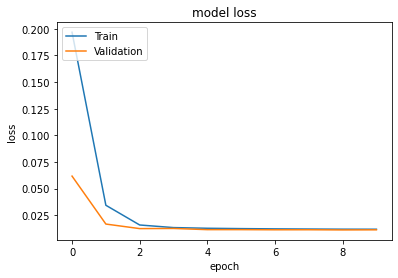

Iteration:  24435
Epoch 1/10
85/85 [==============================] - 21s 250ms/step - loss: 0.0118 - mse: 0.0114 - val_loss: 0.0104 - val_mse: 0.0099
Epoch 2/10
85/85 [==============================] - 21s 246ms/step - loss: 0.0118 - mse: 0.0114 - val_loss: 0.0103 - val_mse: 0.0099
Epoch 3/10
85/85 [==============================] - 21s 250ms/step - loss: 0.0118 - mse: 0.0114 - val_loss: 0.0103 - val_mse: 0.0099
Epoch 4/10
85/85 [==============================] - 21s 252ms/step - loss: 0.0118 - mse: 0.0114 - val_loss: 0.0105 - val_mse: 0.0101
Epoch 5/10
85/85 [==============================] - 21s 251ms/step - loss: 0.0117 - mse: 0.0114 - val_loss: 0.0103 - val_mse: 0.0099
Epoch 6/10
85/85 [==============================] - 21s 253ms/step - loss: 0.0117 - mse: 0.0114 - val_loss: 0.0103 - val_mse: 0.0100
Epoch 7/10
85/85 [==============================] - 21s 253ms/step - loss: 0.0117 - mse: 0.0114 - val_loss: 0.0103 - val_mse: 0.0099
Epoch 8/10
85/85 [==============================] -

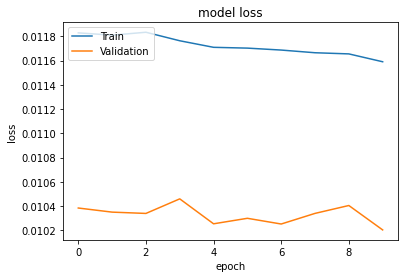

Train MSE


0.011125243554225738



Test MSE


0.010387813629743503



Train MAE


0.08357830284425868



Test MAE


0.07892311103503499

In [30]:
def test_model(X1, X2, y, train_pct):

    mse_test, y_test_all, y_hat_all, y_train = eval_model(None, X1, X2, y, train_pct=train_pct, epoch=10, **best_hyper)

    return mse_test, y_test_all, y_hat_all, y_train

mse_test, y_test_all, y_hat_all, y_train = test_model(X1, X2, y, 0.9)

In [31]:
def inverse_scaling(y, filtered_data):

    y = y*(max(filtered_data['bps']) - min(filtered_data['bps'])) + min(filtered_data['bps'])

    return y

y_hat_all = inverse_scaling(y_hat_all, filtered_data)
y_test_all = inverse_scaling(y_test_all, filtered_data)
y_name[:,:,2] = inverse_scaling(y_name[:,:,2], filtered_data)

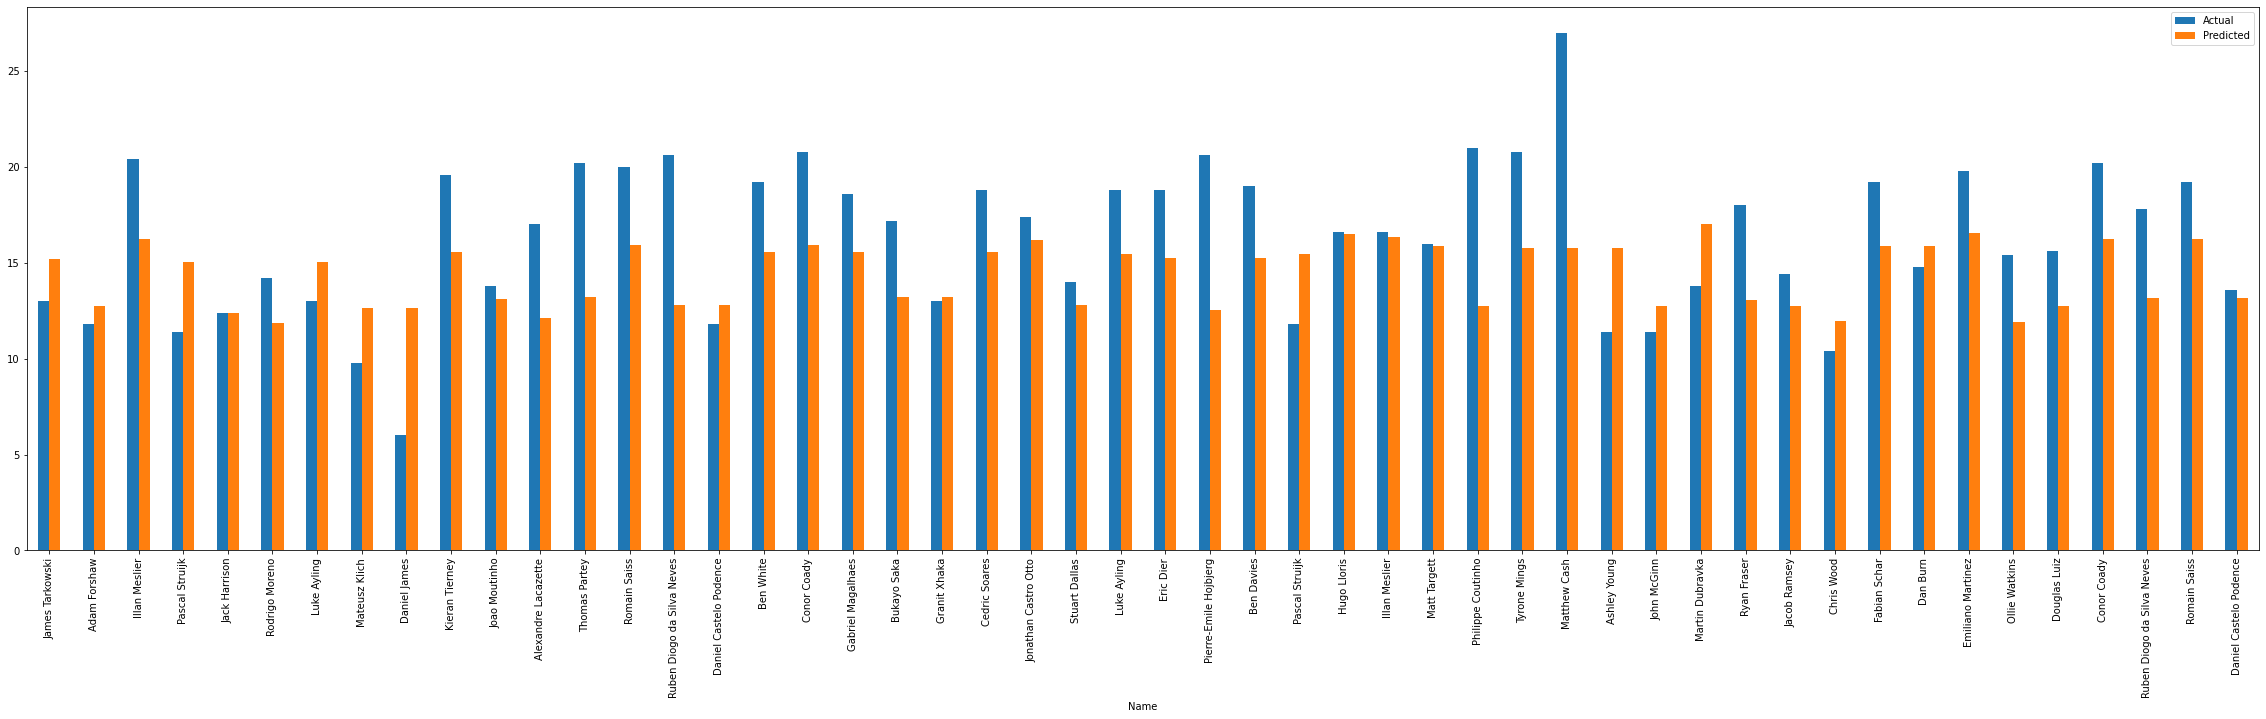

In [34]:
def plot_results(y_hat, y_test, y_name_):

    y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1], y_test.shape[2])

    # add name
    name = y_name_[(y_name_.shape[0]-y_test.shape[0]):y_name_.shape[0],0,1]
    name = name.reshape(name.shape[0],1)
    y_test = np.append(name, y_test, axis=1)

    preds = np.append(y_test,y_hat.reshape(y_hat.shape[0],1),axis=1)
    preds = pd.DataFrame(preds,columns=['Name','Actual','Predicted'])
    preds.set_index('Name',inplace=True)

    fig, ax = plt.subplots(figsize=(40,10))
    preds[-50:].plot(kind='bar',ax=ax)
    plt.show()

plot_results(y_hat_all, y_test_all, y_name)